In [2]:
import pandas as pd
import json
import requests
import time
import numpy as np
from functools import reduce
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pickle

import keras as keras
from keras.models import Model
from keras.models import load_model
import pandas as pd
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [3]:
# commonly used variables

symbol = "AAPL";
apikey = "V1SZPLE0U8CCXSFW.";
datatype = "json";
url = "https://www.alphavantage.co/query";
outputsize = "full";
interval = "daily";
timeperiod = "10";
seriestype = "close";
index = "date";
plt.style.use('seaborn');

In [4]:
# Time Series Data

parameters = {'function':'TIME_SERIES_DAILY_ADJUSTED', 'outputsize':outputsize,'datatype':datatype,'apikey':apikey,'symbol':symbol}

response = requests.get(url, params = parameters);
data = response.json()

AAPL_TS_data = pd.DataFrame(data["Time Series (Daily)"]).T

AAPL_TS_data.reset_index(inplace=True);
AAPL_TS_data.rename(columns={'index': 'date'}, inplace=True);

AAPL_TS_data.rename(columns={'1. open': 'open'}, inplace=True);
AAPL_TS_data.rename(columns={'2. high': 'high'}, inplace=True);
AAPL_TS_data.rename(columns={'3. low': 'low'}, inplace=True);
AAPL_TS_data.rename(columns={'4. close': 'close'}, inplace=True);
AAPL_TS_data.rename(columns={'5. adjusted close': 'adjusted close'}, inplace=True);
AAPL_TS_data.rename(columns={'6. volume': 'volume'}, inplace=True);
AAPL_TS_data.rename(columns={'7. dividend amount': 'dividend amount'}, inplace=True);
AAPL_TS_data.rename(columns={'8. split coefficient': 'split coefficient'}, inplace=True);

# Let's add another column to the frame which is the adjusted close data shifted by 10 days which is what we want to predict

AAPL_TS_data["Target"] = AAPL_TS_data["adjusted close"].shift(-10);

# Now that we donot have the data of the future we need to clip the dataframe where the target is not defined 
AAPL_TS_data = AAPL_TS_data.dropna()

display(AAPL_TS_data.tail())
display(AAPL_TS_data.info())

,date,open,high,low,close,adjusted close,volume,dividend amount,split coefficient,Target
5245,2018-11-05,204.3000,204.3900,198.1700,201.5900,200.8866,66163669,0.0000,1.0000,185.8600
5246,2018-11-06,201.9200,204.7200,201.6900,203.7700,203.0590,31882881,0.0000,1.0000,176.9800
5247,2018-11-07,205.9700,210.0600,204.1300,209.9500,209.2175,33424434,0.0000,1.0000,176.7800
5248,2018-11-08,209.9800,210.1200,206.7500,208.4900,208.4900,25362636,0.7300,1.0000,172.2900
5249,2018-11-09,205.5500,206.0100,202.2500,204.4700,204.4700,34365750,0.0000,1.0000,173.1500


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5250 entries, 0 to 5249
Data columns (total 10 columns):
date                 5250 non-null object
open                 5250 non-null object
high                 5250 non-null object
low                  5250 non-null object
close                5250 non-null object
adjusted close       5250 non-null object
volume               5250 non-null object
dividend amount      5250 non-null object
split coefficient    5250 non-null object
Target               5250 non-null object
dtypes: object(10)
memory usage: 451.2+ KB


None

In [5]:
## Wait for it !!!!!!

#Let's plot the time series data and see what that looks like
#Athough first we will have to convert the data into matplot readable format
#Thus we won't play with actual data but make a copy of it.

AAPL_TS_plotdata = AAPL_TS_data;
AAPL_TS_plotdata['open'] = pd.to_numeric(AAPL_TS_plotdata['open']);
AAPL_TS_plotdata['high'] = pd.to_numeric(AAPL_TS_plotdata['high']);
AAPL_TS_plotdata['low'] = pd.to_numeric(AAPL_TS_plotdata['low']);
AAPL_TS_plotdata['close'] = pd.to_numeric(AAPL_TS_plotdata['close']);
AAPL_TS_plotdata['adjusted close'] = pd.to_numeric(AAPL_TS_plotdata['adjusted close']);
AAPL_TS_plotdata['volume'] = pd.to_numeric(AAPL_TS_plotdata['volume']);
AAPL_TS_plotdata['dividend amount'] = pd.to_numeric(AAPL_TS_plotdata['dividend amount']);
AAPL_TS_plotdata['split coefficient'] = pd.to_numeric(AAPL_TS_plotdata['split coefficient']);
AAPL_TS_plotdata['Target'] = pd.to_numeric(AAPL_TS_plotdata['Target']);

AAPL_TS_plotdata['date']=pd.to_datetime(AAPL_TS_plotdata['date']);
AAPL_TS_plotdata['date'] = AAPL_TS_plotdata['date'].astype(dt.datetime);
AAPL_TS_plotdata = AAPL_TS_plotdata.set_index('date');

#AAPL_TS_plotdata = AAPL_TS_plotdata.drop(['volume','dividend amount','split coefficient','open','high','Target','low'], axis=1);

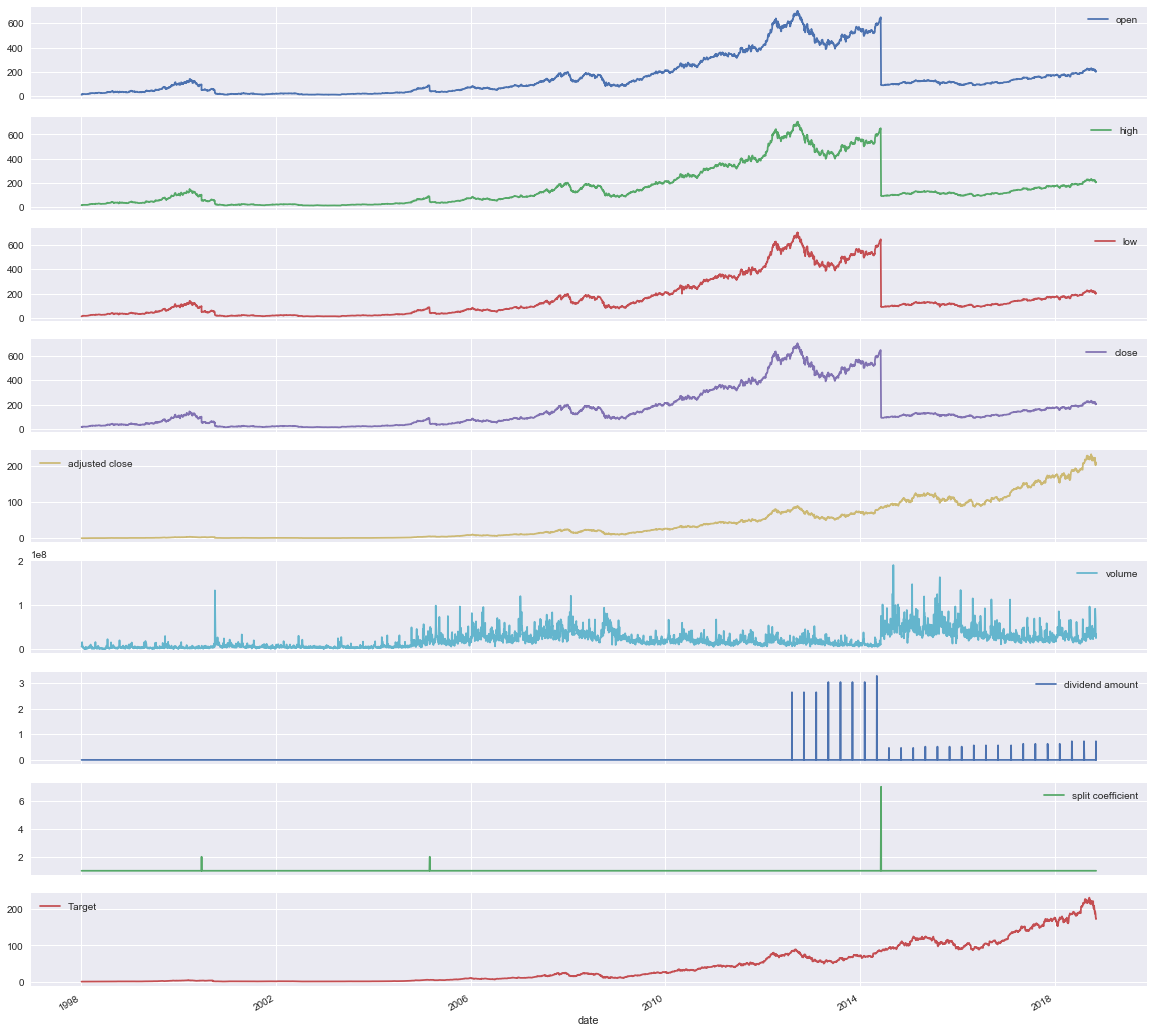

In [8]:
AAPL_TS_plotdata.plot(kind='line', subplots=True, grid=True,figsize=(20, 20));

In [ ]:
#ADX Data

parameters = {'function':'ADX', 'interval':interval,'time_period':timeperiod,'datatype':datatype,'apikey':apikey,'symbol':symbol}

response = requests.get(url, params = parameters);
data = response.json()

AAPL_ADX_data = pd.DataFrame(data["Technical Analysis: ADX"]).T

AAPL_ADX_data.reset_index(inplace=True);
AAPL_ADX_data.rename(columns={'index': 'date'}, inplace=True);

display(AAPL_ADX_data.head())
display(AAPL_ADX_data.info())

In [ ]:
## Wait for it....!!!
#Let's visualize this data and see what it looks like

AAPL_ADX_plotdata = AAPL_ADX_data;
AAPL_ADX_plotdata['date']=pd.to_datetime(AAPL_ADX_plotdata['date']);
AAPL_ADX_plotdata['ADX'] = pd.to_numeric(AAPL_ADX_plotdata['ADX']);
AAPL_ADX_plotdata['date'] = AAPL_ADX_plotdata['date'].astype(dt.datetime);
AAPL_ADX_plotdata = AAPL_ADX_plotdata.set_index('date');

In [ ]:
AAPL_ADX_plotdata.plot(subplots=True, figsize=(20, 5));

In [ ]:
#SMA_data

parameters = {'function':'SMA', 'interval':interval,'time_period':timeperiod,'series_type':seriestype,'datatype':datatype,'apikey':apikey,'symbol':symbol}

response = requests.get(url, params = parameters);
data = response.json()

AAPL_SMA_data = pd.DataFrame(data["Technical Analysis: SMA"]).T
AAPL_SMA_data.reset_index(inplace=True);
AAPL_SMA_data.rename(columns={'index': 'date'}, inplace=True);

display(AAPL_SMA_data.head())
display(AAPL_SMA_data.info())

In [ ]:
# MACD_data

parameters = {'function':'MACD', 'interval':interval,'series_type':seriestype,'datatype':datatype,'apikey':apikey,'symbol':symbol}

response = requests.get(url, params = parameters);
data = response.json()

AAPL_MACD_data = pd.DataFrame(data["Technical Analysis: MACD"]).T

AAPL_MACD_data.reset_index(inplace=True);
AAPL_MACD_data.rename(columns={'index': 'date'}, inplace=True);

display(AAPL_MACD_data.head())
display(AAPL_MACD_data.info())

In [ ]:
## Data Preprocessing